In [1]:
import MDAnalysis as mda
#from MDAnalysis.tests.datafiles import PSF, DCD, CRD, DCD2, PDB_small
from MDAnalysis.analysis import distances,diffusionmap, align, rms,contacts,dihedrals, encore
from MDAnalysis.analysis.rms import RMSF
import mdtraj as md
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as ptch
import matplotlib.ticker as ticker
import matplotlib.animation as animation
from mpl_toolkits.axisartist.parasite_axes import SubplotHost
import matplotlib.pylab as pylab
import matplotlib.patches as mpatches
from itertools import product
import timeit
import time
import math
import os.path
import seaborn as sns
import pandas as pd
import csv
from matplotlib.colors import to_rgb
from matplotlib.collections import PolyCollection
from matplotlib.legend_handler import HandlerTuple
import scipy.signal as sig
from scipy.stats import gaussian_kde
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import scipy.integrate as integrate
import scipy.special as special

In [ ]:
path='/net/gpfs-amarolab/fiona/sars-cov-2/protease/dimer/analysis/'
u_wta=mda.Universe(path+'wt_mpro_chainA_rep123.pr5.aligned_CA.not_waters_or_ions.psf',path+'wt_mpro_chainA_rep123.pr5.aligned_CA.not_waters.dcd')
u_wtb=mda.Universe(path+'wt_mpro_chainB_rep123.pr5.aligned_CA.not_waters_or_ions.psf',path+'wt_mpro_chainB_rep123.pr5.aligned_CA.not_waters.dcd')

u_dma=mda.Universe(path+'dm_mpro_chainA_rep123.pr5.aligned_CA.not_waters_or_ions.psf',path+'dm_mpro_chainA_rep123.pr5.aligned_CA.not_waters.dcd')
u_dmb=mda.Universe(path+'dm_mpro_chainB_rep123.pr5.aligned_CA.not_waters_or_ions.psf',path+'dm_mpro_chainB_rep123.pr5.aligned_CA.not_waters.dcd')

u_delP168a=mda.Universe(path+'delP168_mpro_chainA_rep123.pr5.aligned_CA.not_waters_or_ions.psf',path+'delP168_mpro_chainA_rep123.pr5.aligned_CA.not_waters.dcd')
u_delP168b=mda.Universe(path+'delP168_mpro_chainB_rep123.pr5.aligned_CA.not_waters_or_ions.psf',path+'delP168_mpro_chainB_rep123.pr5.aligned_CA.not_waters.dcd')

u_a173va=mda.Universe(path+'a173v_mpro_chainA_rep123.pr5.aligned_CA.not_waters_or_ions.psf',path+'a173v_mpro_chainA_rep123.pr5.aligned_CA.not_waters.dcd')
u_a173vb=mda.Universe(path+'a173v_mpro_chainB_rep123.pr5.aligned_CA.not_waters_or_ions.psf',path+'a173v_mpro_chainB_rep123.pr5.aligned_CA.not_waters.dcd')

In [16]:
def calc_m49_s2(u,title):
    dist=[]
    m49=u.select_atoms("resid 49")
    s2=u.select_atoms("resid 165-167 188-192 and name CA")
    for ts in u.trajectory:
        dist_arr = distances.distance_array(m49.center_of_geometry(),s2.center_of_geometry())
        dist.append((np.min(dist_arr)))
    print("Finished")
    
    results=np.array(dist).reshape(len(dist),1)
    
    with open('{}_m49_s2_contacts.npy'.format(title),'wb') as f:
        np.save(f,results)
    
    
    return(results)

In [5]:
data_dir='/net/gpfs-amarolab/fiona/sars-cov-2/protease/'
wta_dat=np.load(data_dir+'wta_m49_s2_contacts.npy')
wtb_dat=np.load(data_dir+'wtb_m49_s2_contacts.npy')
dma_dat=np.load(data_dir+'dma_m49_s2_contacts.npy')
dmb_dat=np.load(data_dir+'dmb_m49_s2_contacts.npy')
delP168a_dat=np.load(data_dir+'delP168a_m49_s2_contacts.npy')
delP168b_dat=np.load(data_dir+'delP168b_m49_s2_contacts.npy')
a173va_dat=np.load(data_dir+'a173va_m49_s2_contacts.npy')
a173vb_dat=np.load(data_dir+'a173vb_m49_s2_contacts.npy')

In [ ]:
wta_dat=calc_m49_s2(u_wta,"wta")
wtb_dat=calc_m49_s2(u_wtb,"wtb")

In [23]:
dma_dat=calc_m49_s2(u_dma,"dma")
dmb_dat=calc_m49_s2(u_dmb,"dmb")

Finished
Finished


In [24]:
delP168a_dat=calc_m49_s2(u_delP168a,"delP168a")
delP168b_dat=calc_m49_s2(u_delP168b,"delP168b")

Finished
Finished


In [25]:
a173va_dat=calc_m49_s2(u_a173va,"a173va")
a173vb_dat=calc_m49_s2(u_a173vb,"a173vb")

Finished
Finished


(array([31753., 22088., 17808., 73487., 37092., 48490., 46372., 35289.,
        16379.,  1242.]),
 array([ 0.16845198,  3.03181909,  5.8951862 ,  8.75855331, 11.62192042,
        14.48528753, 17.34865464, 20.21202175, 23.07538886, 25.93875597,
        28.80212308]),
 <BarContainer object of 10 artists>)

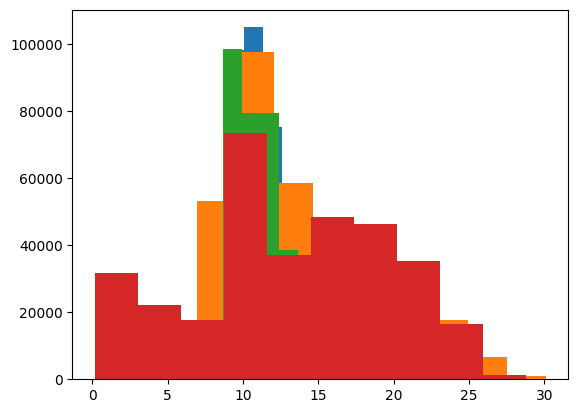

In [26]:
plt.hist(wta_dat[:,0])
plt.hist(dma_dat[:,0])
plt.hist(delP168a_dat[:,0])
plt.hist(a173va_dat[:,0])

In [35]:
def plot_distributions(wt,dm,delP168,a173v,title):
    params = {
         'font.family': 'sans-serif',
         'font.sans-serif': 'Arial',
         'legend.fontsize': '36',
         #'figure.figsize': (24,12),
         'axes.labelsize': '40',
         'axes.titlesize': '40',
         'xtick.labelsize': '30',
         'ytick.labelsize': '30'
         #'xtick.size': '30'
         #'ytick.size': '30'
    }
    
    pylab.rcParams.update(params)
    
    def calc_auc(function):
        auc0_percent=math.floor(integrate.quad(function,0,8)[0]*100)
        auc1_percent=math.floor(integrate.quad(function,8,15)[0]*100)
        auc2_percent=math.floor(integrate.quad(function,15,30)[0]*100)
        return(auc0_percent,auc1_percent,auc2_percent)
    
    collection=wt+dm+delP168+a173v
    start=np.min(collection)-1
    stop=np.max(collection)+1
    
    domain = np.linspace(start,stop,1000)
    dens_wt = gaussian_kde(wt)
    dens_wt.covariance_factor = lambda : 0.25
    dens_dm = gaussian_kde(dm)
    dens_dm.covariance_factor = lambda : 0.25
    dens_delP168 = gaussian_kde(delP168)
    dens_delP168.covariance_factor = lambda : 0.25
    dens_a173v = gaussian_kde(a173v)
    dens_a173v.covariance_factor = lambda : 0.25
    
    #fig = plt.figure(figsize=(12,8))
    fig, axs = plt.subplots(1,1, sharex=True, sharey=True, tight_layout=True, figsize=(16,12))
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    
    wt_auc0,wt_auc1,wt_auc2=calc_auc(dens_wt)
    dm_auc0,dm_auc1,dm_auc2=calc_auc(dens_dm)
    delP168_auc0,delP168_auc1,delP168_auc2=calc_auc(dens_delP168)
    a173v_auc0,a173v_auc1,a173v_auc2=calc_auc(dens_a173v)
    
    ## plot a_XXX's together
    axs.axvline(x=8,color='lightgrey',linestyle='-')
    axs.axvline(x=15,color='lightgrey',linestyle='-')
    p1, = axs.plot(domain,dens_wt(domain),color='cornflowerblue',alpha=1.0,linewidth=10,label='WT') ## column 2 = interface 1
    axs.fill_between(domain,dens_wt(domain),color='cornflowerblue',alpha=0.2)
    p2, = axs.plot(domain,dens_dm(domain),color='burlywood',alpha=1.0,linewidth=10,label='DM') ## column 2 = interface 1
    axs.fill_between(domain,dens_dm(domain),color='burlywood',alpha=0.2)
    p3, = axs.plot(domain,dens_delP168(domain),color='peru',alpha=1.0,linewidth=10,label="$\Delta$P168") ## column 2 = interface 1
    axs.fill_between(domain,dens_delP168(domain),color='peru',alpha=0.2)
    p4, = axs.plot(domain,dens_a173v(domain),color='saddlebrown',alpha=1.0,linewidth=10,label='A173V') ## column 2 = interface 1
    axs.fill_between(domain,dens_a173v(domain),color='saddlebrown',alpha=0.2)
    axs.set_ylim([0,0.3])
    axs.set_xlim([0,30])
    
    #axs.annotate("WT {}%".format(wt_auc0),(0.5,0.24),xycoords='data',fontsize=16)
    #axs.annotate("DM {}%".format(dm_auc0),(0.5,0.23),xycoords='data',fontsize=16)
    #axs.annotate("$\Delta$P168 {}%".format(delP168_auc0),(0.5,0.22),xycoords='data',fontsize=16)
    #axs.annotate("A173V {}%".format(a173v_auc0),(0.5,0.21),xycoords='data',fontsize=16)
    #axs.annotate("WT {}%".format(wt_auc1),(12,0.24),xycoords='data',fontsize=16)
    #axs.annotate("DM {}%".format(dm_auc1),(12,0.23),xycoords='data',fontsize=16)
    #axs.annotate("$\Delta$P168 {}%".format(delP168_auc1),(12,0.22),xycoords='data',fontsize=16)
    #axs.annotate("A173V {}%".format(a173v_auc1),(12,0.21),xycoords='data',fontsize=16)
    #axs.annotate("WT {}%".format(wt_auc2),(16,0.24),xycoords='data',fontsize=16)
    #axs.annotate("DM {}%".format(dm_auc2),(16,0.23),xycoords='data',fontsize=16)
    #axs.annotate("$\Delta$P168 {}%".format(delP168_auc2),(16,0.22),xycoords='data',fontsize=16)
    #axs.annotate("A173V {}%".format(a173v_auc2),(16,0.21),xycoords='data',fontsize=16)
    
    #plt.title("Distribution of C145-S to H41-N Dist")
    plt.ylabel("Density",labelpad=40)
    plt.xlabel("M49 to S3/4 Pocket Dist ($\AA{}$)")
    
    
    #plt.legend(fontsize=36)
    lgd=plt.legend(handles=[p1, p3, p4, p2], bbox_to_anchor=(1.0,-0.1),ncol=4,fancybox=True,fontsize=36)
    fig.tight_layout()
    plt.savefig('{}_m49_s2_penetration_dist.png'.format(title),bbox_extra_artists=(lgd,),bbox_inches='tight',dpi=300)

In [36]:
wt_all=wta_dat[:,0].tolist()+wtb_dat[:,0].tolist()
dm_all=dma_dat[:,0].tolist()+dmb_dat[:,0].tolist()
delP168_all=delP168a_dat[:,0].tolist()+delP168b_dat[:,0].tolist()
a173v_all=a173va_dat[:,0].tolist()+a173vb_dat[:,0].tolist()

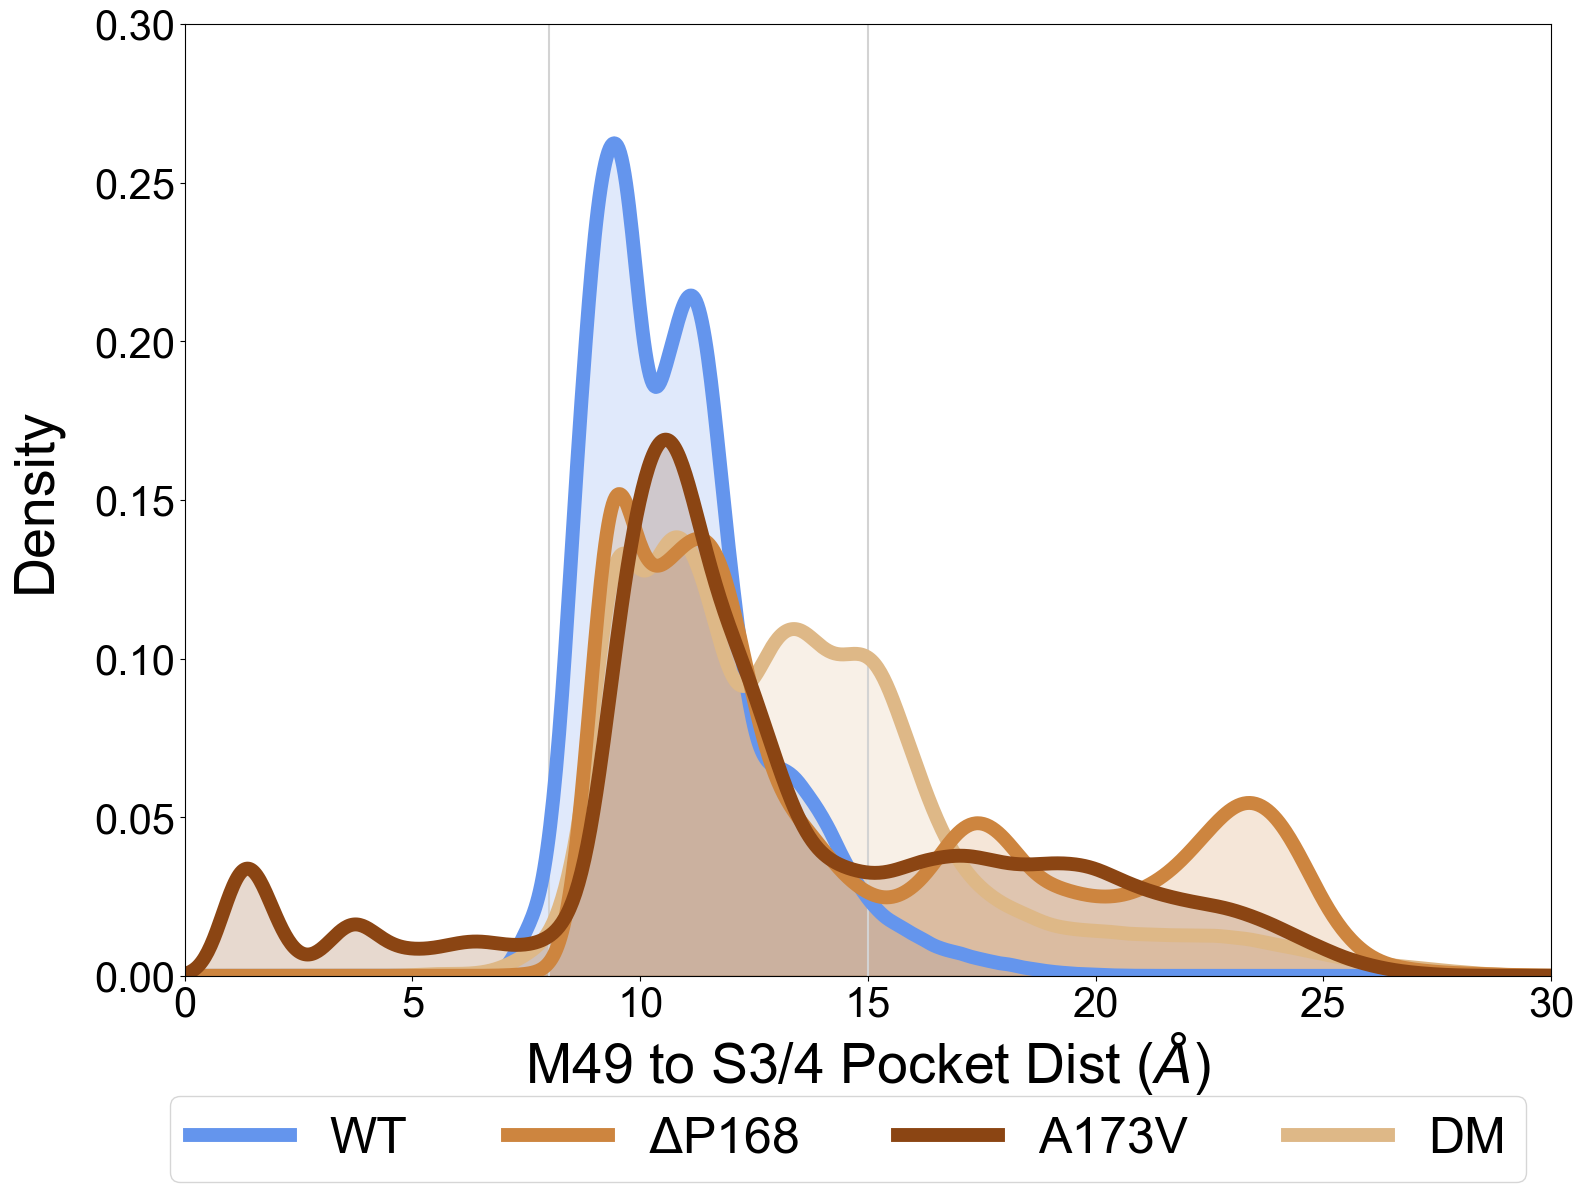

In [37]:
plot_distributions(wt_all,dm_all,delP168_all,a173v_all,"wt_dm_delP168_a173v")